<a href="https://colab.research.google.com/github/furk4neg3/image-segmentation/blob/main/PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (3/3), done.


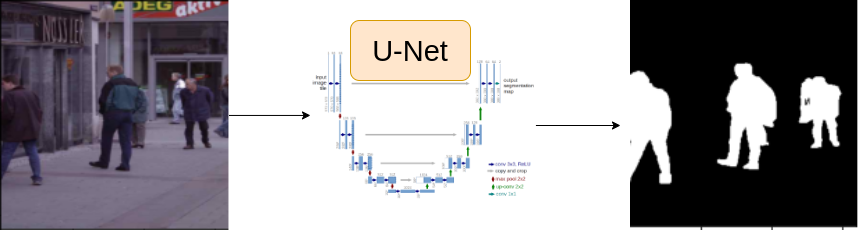

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER ='timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

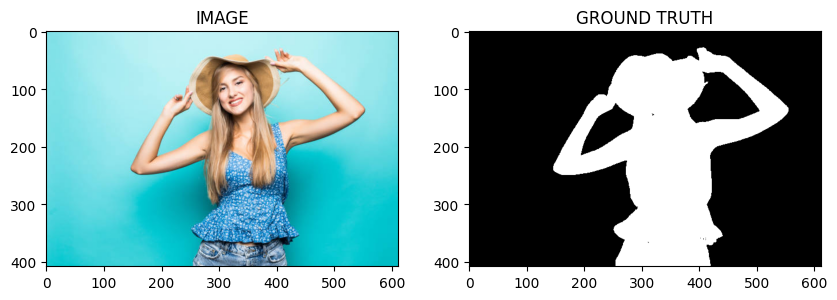

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [28]:
import albumentations as A

def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ], is_check_shapes=False) # Added is_check_shapes=False

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ], is_check_shapes=False)  # Added is_check_shapes=False

# Task 4 : Create Custom Dataset

In [29]:
from torch.utils.data import Dataset

In [30]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [31]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [32]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


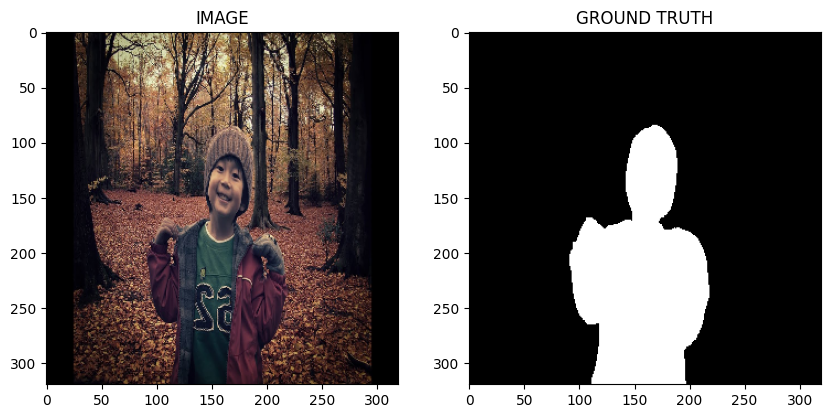

In [34]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [35]:
from torch.utils.data import DataLoader

In [36]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)

In [37]:
print(f"Total number of batches in trainloader: {len(train_loader)}")
print(f"Total number of batches in validloader: {len(valid_loader)}")

Total number of batches in trainloader: 15
Total number of batches in validloader: 4


In [38]:
for image, mask in train_loader:
  break

print(f"image shape : {image.shape}")
print(f"mask shape : {mask.shape}")

image shape : torch.Size([16, 3, 320, 320])
mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [39]:
  from torch import nn
  import segmentation_models_pytorch as smp
  from segmentation_models_pytorch.losses import DiceLoss

In [51]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None,
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [53]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [54]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [55]:
def eval_fn(data_loader, model, optimizer):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [65]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model, optimizer)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")

  print(f"Epoch : {i+1}/25 || Train Loss : {train_loss:.4f} || Valid Loss : {valid_loss:.4f}")

100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


SAVED MODEL
Epoch : 1/25 || Train Loss : 0.0630 || Valid Loss : 0.1902


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


SAVED MODEL
Epoch : 2/25 || Train Loss : 0.0566 || Valid Loss : 0.1892


100%|██████████| 4/4 [00:00<00:00,  6.44it/s]


SAVED MODEL
Epoch : 3/25 || Train Loss : 0.0550 || Valid Loss : 0.1851


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


SAVED MODEL
Epoch : 4/25 || Train Loss : 0.0538 || Valid Loss : 0.1720


100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


SAVED MODEL
Epoch : 5/25 || Train Loss : 0.0521 || Valid Loss : 0.1692


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Epoch : 6/25 || Train Loss : 0.0542 || Valid Loss : 0.1938


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Epoch : 7/25 || Train Loss : 0.0549 || Valid Loss : 0.2573


100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


Epoch : 8/25 || Train Loss : 0.0557 || Valid Loss : 0.1891


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Epoch : 9/25 || Train Loss : 0.0534 || Valid Loss : 0.1737


100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


Epoch : 10/25 || Train Loss : 0.0522 || Valid Loss : 0.1823


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Epoch : 11/25 || Train Loss : 0.0557 || Valid Loss : 0.1854


100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


Epoch : 12/25 || Train Loss : 0.0518 || Valid Loss : 0.2020


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Epoch : 13/25 || Train Loss : 0.0511 || Valid Loss : 0.2001


100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


Epoch : 14/25 || Train Loss : 0.0525 || Valid Loss : 0.1931


100%|██████████| 4/4 [00:00<00:00,  6.47it/s]


Epoch : 15/25 || Train Loss : 0.0537 || Valid Loss : 0.1744


100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


SAVED MODEL
Epoch : 16/25 || Train Loss : 0.0552 || Valid Loss : 0.1615


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Epoch : 17/25 || Train Loss : 0.0495 || Valid Loss : 0.1768


100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Epoch : 18/25 || Train Loss : 0.0490 || Valid Loss : 0.1683


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Epoch : 19/25 || Train Loss : 0.0534 || Valid Loss : 0.2038


100%|██████████| 4/4 [00:00<00:00,  6.45it/s]


Epoch : 20/25 || Train Loss : 0.0620 || Valid Loss : 0.2472


100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


Epoch : 21/25 || Train Loss : 0.0727 || Valid Loss : 0.2138


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch : 22/25 || Train Loss : 0.0694 || Valid Loss : 0.2862


100%|██████████| 4/4 [00:00<00:00,  6.45it/s]


Epoch : 23/25 || Train Loss : 0.1076 || Valid Loss : 0.2560


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch : 24/25 || Train Loss : 0.1079 || Valid Loss : 0.2697


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]

Epoch : 25/25 || Train Loss : 0.0931 || Valid Loss : 0.2939


# Task 9 : Inference

In [63]:
idx = 20

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-63-8d39d9ac543f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


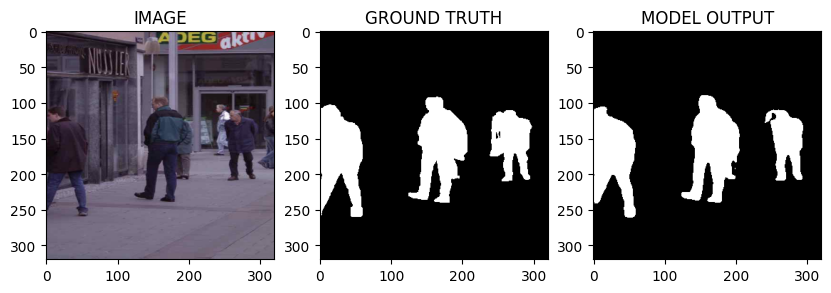

In [64]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))